# Итерационные методы для собственных значений

## PINVIT

- Идея - минимизировать отношение Релея
- Используем градиентный спуск предобусловленный матрицей $(A - \sigma I)$ 

In [1]:
import numpy as np
import scipy.sparse.linalg as spsplin
import scipy.sparse as spsp

def pinvit(A, x0, sigma, tau, num_iter, tol, inexact=True):
    n = A.shape[0]
    if inexact:
        splu = spsplin.spilu(A - sigma * spsp.eye(n))
    else:
        splu = spsplin.splu(A - sigma * spsp.eye(n))
#     splu = spsplin.splu(spsp.eye(n))
    x = x0.copy()
    conv = [x]
    for k in range(num_iter):
        lam = (x @ A @ x) / (x @ x)
        x = x - tau * splu.solve(A @ x - lam * x)
        conv.append(x)
        if np.linalg.norm(A @ x - lam * x) < tol:
            break
    return x, (x @ A @ x) / (x @ x), conv

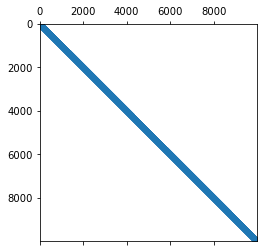

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
n = 100
ex = np.ones(n)
lp1 = spsp.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr')
e = spsp.eye(n)
A = spsp.kron(lp1, e) + spsp.kron(e, lp1)
plt.spy(A, markersize=1)

In [3]:
true_eigval, true_eigvec = spsplin.eigsh(A, which="SM", k=1)
print(true_eigval)
x0 = np.random.randn(A.shape[0])
pinvit_eigvec, pinvit_eigval, conv_pinvit_inexact = pinvit(A, x0, 0, 1, 300, 1e-6, True)
print(pinvit_eigval)
pinvit_eigvec, pinvit_eigval, conv_pinvit_exact = pinvit(A, x0, 0, 1, 100, 1e-6, False)
print(pinvit_eigval)

[-0.00193487]


/Users/alex/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:407: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


-0.0019686253609045804
-0.0019348708320477428


/Users/alex/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


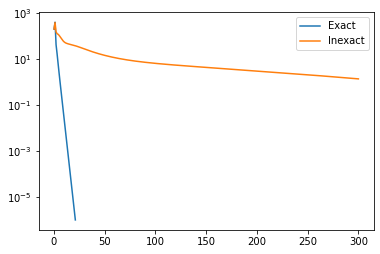

In [4]:
plt.semilogy([np.linalg.norm(A @ x - (x @ A @ x) * x / (x @ x)) for x in conv_pinvit_exact], label="Exact")
plt.semilogy([np.linalg.norm(A @ x - (x @ A @ x) * x / (x @ x)) for x in conv_pinvit_inexact], label="Inexact")
plt.legend()

In [5]:
def shift_inverse_iteration_fast(A, x0, num_iter, shift, tol):
    x = x0.copy()
    conv = [x]
    n = A.shape[0]
    splu = spsplin.splu(A - shift * spsp.eye(n))
    for i in range(num_iter):
        x = splu.solve(x)
        x = x / np.linalg.norm(x)
        conv.append(x)
        if np.linalg.norm(A @ x - x @ A @ x * x) < tol:
            break
    return x, conv

In [6]:
shift = 0.
num_iter = 100
tol=1e-6
middle_eigv, conv_m = shift_inverse_iteration_fast(A, x0, num_iter, shift, tol)
print(middle_eigv @ A @ middle_eigv)

-0.0019348708932758179


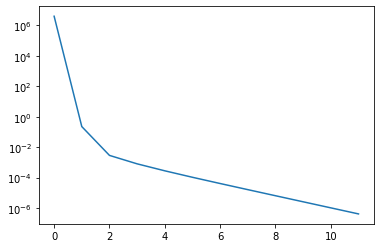

In [7]:
plt.semilogy([np.linalg.norm(A @ x - (x @ A @ x) * x) for x in conv_m])

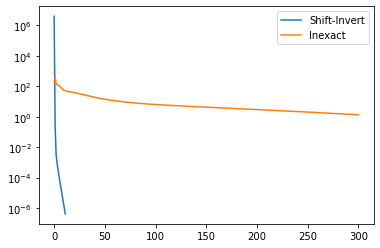

In [8]:
plt.semilogy([np.linalg.norm(A @ x - (x @ A @ x) * x) for x in conv_m], label="Shift-Invert")
# plt.semilogy([np.linalg.norm(A @ x - (x @ A @ x) * x / (x @ x)) for x in conv_pinvit_exact], label="Exact")
plt.semilogy([np.linalg.norm(A @ x - (x @ A @ x) * x / (x @ x)) for x in conv_pinvit_inexact], label="Inexact")
plt.legend()